###**TRANSFORMER:**

This program consists in implementing the transformer proposed in "Attention is All you Need" and applying it to meteorological forecasts.
A transformer is composed by an encoder, which takes a sequence in input and processes it using self attention, and a decoder, which processes (in the case of prediction of some value) the final n elements of the input sequence concatenated to zeros (which represent the elements to predict), using a self attention. The decoder then takes in the encoder output and performs a cross attention between decoder-processed input and encoder-processed input, and generates an output.

**NOTE:** There are some intermediate secondary processes which are not specified here.

**NOTE:** Inputs in encoder and decoder are first processed by using a positional and temporal embedding, and using an initial convolution on entering features.

**NOTE:**  Code is different from other algorithms of the project only for what regards the network and relative classes, hyperparameters and utilized data.

In [168]:
import numpy as np
from math import sqrt
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import os
import time
import pickle as pc
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from functools import partial
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import KFold
import random


class EarlyStopping:  #definisco un early stopping da utilizzare nella fase di training. Se la vlaidation non migliora per un tot di epoche, allora si intterrompe il train. Evita overfitting
    def __init__(self, patience, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss

In [169]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**DATA PROCESSING:**

In [170]:
df = pd.read_csv("/content/drive/MyDrive/MeteoGNN/Codici_e_Dataframe/FullDataFrame_5Stations_MR.csv").dropna()#carico i dati in un dataframe prendendo un dato ogni ora, quindi ogni 6 righe
df['DATE'] = pd.to_datetime(df['DATE'])
df['hour']=df['DATE'].dt.hour
df['month']=df.DATE.dt.month
lunghezza_finestra = 3
deviazioni_standard_reali = []
# Calcoliamo la deviazione standard su finestre di dati
for i in range(len(df) - lunghezza_finestra):
    finestra = df.TEMP_STA4.values[i:i+lunghezza_finestra]
    deviazione_standard = np.std(finestra)
    deviazioni_standard_reali.append(deviazione_standard)
df=df[lunghezza_finestra:]
df['STD4']=np.array(deviazioni_standard_reali)
# Le deviazioni standard calcolate rappresentano la variazione nel tempo
#print(deviazioni_standard_reali)
col0= ['DATE', "HUM_STA4", 'PRESS_STA4', 'TEMP_STA4','STD4']
df=df[col0].dropna()
co = df.columns[1:]
df = df.reset_index(drop=True)
df

,DATE,HUM_STA4,PRESS_STA4,TEMP_STA4,STD4
0,2017-12-31 23:30:00,2.761485,1017.1,-3.7,0.047140
1,2017-12-31 23:40:00,2.752909,1017.1,-3.7,0.047140
2,2017-12-31 23:50:00,2.683641,1017.1,-3.9,0.047140
3,2018-01-01 00:00:00,2.689993,1017.0,-3.8,0.094281
4,2018-01-01 00:10:00,2.701610,1016.9,-3.8,0.081650
...,...,...,...,...,...
288008,2023-06-30 21:10:00,6.944306,1011.4,8.6,0.047140
288009,2023-06-30 21:20:00,6.896224,1011.5,8.5,0.047140
288010,2023-06-30 21:30:00,6.849126,1011.5,8.4,0.081650
288011,2023-06-30 21:40:00,6.848442,1011.6,8.4,0.081650


In [171]:
from datetime import datetime, timedelta
df = df.reset_index(drop=True)

In [172]:
fea = df.shape[1]-1#numero totale di features utilizzate, da passare poi al modello
print(fea)

4


Dal momento che i dati dalle stazioni sono spesso mancanti e presentano diversi nan si è deciso di implementare un meccanismo di salto delle batch, che fa sì che le sequenze che costituiscono le batch siano costruite in maniera tale da non presentare discontinuità.

In [173]:
desired_interval =1008#equivale a 7 giorni              #Intervallo di tempo senza dati mancanti che vogliamo; deve essere maggiore o uguale a seq_len+pred_len
df["DATE"]=pd.to_datetime(df["DATE"])
desired_duration = timedelta(days=7)
good_starts = []
for i in range(df.shape[0]-desired_interval):                                      #Creo vettore di indici buoni per selezionare sequenze senza salti
    if df["DATE"][i+desired_interval]-df["DATE"][i] == desired_duration:
        good_starts.append(df.index[i])                                           #SE VUOI PREVEDERE IL VENTO VA COMMENTATA QUESTA RIGA
fea = df.shape[1]-1
good_starts_train = good_starts[0:int(len(good_starts)*0.8)]            #Divido il vettore good_starts in indici iniziali di train e di validation
good_starts_vali = good_starts[int(len(good_starts)*0.8):int(len(good_starts)*0.9)]
good_starts_vali = [l for l in good_starts_vali if l>(good_starts_train[-1]+desired_interval+1)]
good_starts_test = good_starts[int(len(good_starts)*0.9):int(1*len(good_starts))]
good_starts_test = [l for l in good_starts_test if l>(good_starts_vali[-1]+desired_interval+1)] #Non voglio che train e validation si sovrappongano

shuffled_list = good_starts_train.copy()                                                        #Mischio il train
random.shuffle(shuffled_list)
tr = shuffled_list                                                                     #Scelgo un tot di indici da cui iniziare per le batch di train e un tot per validation
va = good_starts_vali
te =  good_starts_test                                           #Visto che altrimenti il train impiegherebbe giorni
gs=[tr,va,te]                                                                                      #Nel dataloader.train selezionerò il primo array di indici per scegliere indici (gs[0])
df=df[:-1]           #Sistemo gli indici di partenza di vali perchè cosi vuole il programma

In [174]:
class Dataset():#'forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
    def __init__(self, root_path=None, flag='train', size=None,
                 features='MS',target= 'TEMP_STA2', scale=True, timeenc=0, freq='10m'):
        # info sugli input
        # size:lista contenente [seq_len, label_len, pred_len]
        # features: stringa che specifica il tipo di task di previsione
        # target: stringa che specifica la variabile target
        # scale: se True si effettua lo scaling dei dati con MinMax Scaler, altrimenti False
        # timeenc: intero indicante il tipo di encoding temporale
        # freq: stringa che specifica la frequenza

        if size == None:
            print("size è none. Forse ci sono problemi")
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'val', 'test']
        type_map = {'train': 0, 'val': 1, 'test': 2}#flag che specifica il tipo di splitting
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.root_path = root_path
        self.__read_data__()

    def __read_data__(self):#questo metodo effettua una lettura e un preprocessing dei dati
        self.scaler =MinMaxScaler()#scaler che normalizza i dati tra 0 e 1
        self.scaler_std =MinMaxScaler()
        self.scaler_mean =MinMaxScaler()#scaler che normalizza i dati tra 0 e 1
        self.scaler_std =MinMaxScaler()
        df_raw = df
        #border1s e border2s sono liste usate per definire gli estremi degli intervalli sulla base del tipo di splitting
        border1s = [0,
                    0,
                    0]
        border2s = [int(len(df_raw)*1),
                    int(len(df_raw)*1),
                    int(len(df_raw)*1)]#teoricamente se non ci fosse il salto di batch,
                    #border1s[0]=0,border2s[0]=int(len(df_raw))*0.7 per prendere il 70% del dataset in train, e via cosi' con gli altri elementi per validation e test
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]


        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]

        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            stop_index = good_starts_train[-1]+desired_interval
            train_data = df_data.iloc[:stop_index + 1]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
            colonne=['TEMP_STA4','STD4']
            self.scaler_mean.fit(train_data[colonne[0]].values.reshape(-1, 1))
            self.scaler_std.fit(train_data[colonne[1]].values.reshape(-1, 1))

        else:
            data = df_data.values
        df_stamp = df_raw[['DATE']][border1:border2]
        df_stamp['DATE'] = pd.to_datetime(df_stamp.DATE)
        if self.timeenc == 0:#si sceglie la modalità in cui effettuare l'embedding temporale che sarà fatto in seguito a seconda se time enc è 0 oppure 1
            df_stamp['month'] = df_stamp.DATE.apply(lambda row: row.month, 1)
            df_stamp['hour'] = df_stamp.DATE.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(labels=['DATE'], axis=1).values

        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['DATE'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)
        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):#questo metodo è usato per recuperare una specifica sequenza di dati dal dataset dato un certo indice
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]

        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):#ritorna il numero totale di sequenze nel dataset
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform_mean(self, data):# effettua lo scaling inverso dei dati nel caso si sia scelto di riscalarli nel preprocessing
        return self.scaler_mean.inverse_transform(data)
    def inverse_transform_std(self, data):# effettua lo scaling inverso dei dati nel caso si sia scelto di riscalarli nel preprocessing
        return self.scaler_std.inverse_transform(data)


**IMPLEMENTAZIONE DEL MODELLO**:

Di seguito è riportata l'implementazione tramite PyTorch del transformer utilizzato.  

In [175]:
import torch
from torch import nn

In [176]:
class PositionalEmbedding(nn.Module):#Utilizzata per dare una sequenzialità ed un ordine alla sequenza, seno alle colonne pari, coseno a quelle dispari
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):#convoluzione sulle features

    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x

class TimeFeatureEmbedding(nn.Module):#embedding temporale di primo tipo
    def __init__(self, d_model, embed_type='timeF', freq='10m'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6, 'm': 1, 'a': 1, 'w': 2, 'd': 3, 'B': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)




class TemporalEmbedding(nn.Module):#embedding temporale di secondo tipo
    def __init__(self, d_model, embed_type='fixed', freq='m'):
        super(TemporalEmbedding, self).__init__()

        hour_size = 25
        weekday_size = 8
        day_size = 32
        minute_size = 61
        month_size = 13


        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding

        self.hour_embed = Embed(hour_size, d_model)

        self.minute_embed = Embed(minute_size, d_model)
        self.month_embed = Embed(month_size, d_model)




    def forward(self, x):
        x = x.long()
        hour_x = self.hour_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])
        return  month_x+hour_x


class DataEmbedding(nn.Module):#si sommano fra di loro tutti gli embedding
    def __init__(self, c_in, d_model, embed_type='fixed', freq='10m', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq)# if embed_type == 'timeF' else TimeFeatureEmbedding(
            #d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)

class TriangularCausalMask():#maschera il futuro
    def __init__(self, B, L, device="cuda"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)
    @property
    def mask(self):
        return self._mask

class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cuda"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask
class DSAttention(nn.Module):# si applica il meccanismo di attenzione
    '''De-stationary Attention'''
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(DSAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        tau = 1.0 if tau is None else tau.unsqueeze(1).unsqueeze(1)  # B x 1 x 1 x 1
        delta = 0.0 if delta is None else delta.unsqueeze(1).unsqueeze(1)  # B x 1 x 1 x S

        # De-stationary Attention, rescaling pre-softmax score with learned de-stationary factors
        scores = torch.einsum("blhe,bshe->bhls", queries, keys) * tau + delta

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

class AttentionLayer(nn.Module):#attenzione
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau, delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

class EncoderLayer(nn.Module):#ENCODER DEL TRANSFORMER
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))

        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i==0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):#DECODER DEL TRANSFORMER
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])


        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x

class Projector(nn.Module):
    '''
    MLP to learn the De-stationary factors
    '''
    def __init__(self, enc_in, seq_len, hidden_dims, hidden_layers, output_dim, kernel_size=3):
        super(Projector, self).__init__()

        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.series_conv = nn.Conv1d(in_channels=seq_len, out_channels=1, kernel_size=kernel_size, padding=padding, padding_mode='circular', bias=False)

        layers = [nn.Linear(2 * enc_in, hidden_dims[0]), nn.ReLU()]
        for i in range(hidden_layers-1):
            layers += [nn.Linear(hidden_dims[i], hidden_dims[i+1]), nn.ReLU()]

        layers += [nn.Linear(hidden_dims[-1], output_dim, bias=False)]
        self.backbone = nn.Sequential(*layers)

    def forward(self, x, stats):
        # x:     B x S x E
        # stats: B x 1 x E
        # y:     B x O
        batch_size = x.shape[0]
        x = self.series_conv(x)          # B x 1 x E
        x = torch.cat([x, stats], dim=1) # B x 2 x E
        x = x.view(batch_size, -1) # B x 2E
        y = self.backbone(x)       # B x O
        return y


class Model(nn.Module):#si crea finalmente il modello
    """
    Non-stationary Transformer
    """
    def __init__(self, pred_len,seq_len,label_len,d_model,dropout,factor,e_layers,n_heads,d_ff,p_hidden_dims,
                 p_hidden_layers, d_layers, activation='gelu',c_out=fea,freq='10m',enc_in=fea,dec_in=fea,output_attention='store_true',embed='timeF'):
        super(Model, self).__init__()
        self.pred_len = pred_len
        self.seq_len = seq_len
        self.label_len = label_len
        self.output_attention = output_attention
        self.enc_in=enc_in
        self.dec_in=dec_in
        self.d_model=d_model
        self.embed=embed
        self.freq=freq
        self.dropout=dropout
        self.factor=factor
        self.e_layers=e_layers
        self.n_heads=n_heads
        self.d_ff=d_ff
        self.p_hidden_dims=p_hidden_dims
        self.p_hidden_layers=p_hidden_layers
        self.activation=activation
        self.d_layers=d_layers
        self.c_out=c_out


        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq,
                                           dropout)
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq,
                                           dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        DSAttention(False, factor, attention_dropout=dropout,
                                      output_attention=output_attention), d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        DSAttention(True, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        DSAttention(False, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(self.d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, c_out, bias=True)
        )

        self.tau_learner   = Projector(enc_in=enc_in, seq_len=seq_len, hidden_dims=p_hidden_dims, hidden_layers=p_hidden_layers, output_dim=1)
        self.delta_learner = Projector(enc_in=enc_in, seq_len=seq_len, hidden_dims=p_hidden_dims, hidden_layers=p_hidden_layers, output_dim=seq_len)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):

        x_raw = x_enc.clone().detach()
        # Normalization
        mean_enc = x_enc.mean(1, keepdim=True).detach() # B x 1 x E
        x_enc = x_enc - mean_enc
        std_enc = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach() # B x 1 x E
        x_enc = x_enc / std_enc
        x_dec_new = torch.cat([x_enc[:, -self.label_len: , :], torch.zeros_like(x_dec[:, -self.pred_len:, :])], dim=1).to(x_enc.device).clone()

        tau = self.tau_learner(x_raw, std_enc).exp()     # B x S x E, B x 1 x E -> B x 1, positive scalar
        delta = self.delta_learner(x_raw, mean_enc)      # B x S x E, B x 1 x E -> B x S

        # Model Inference
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask, tau=tau, delta=delta)

        dec_out = self.dec_embedding(x_dec_new, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask, tau=tau, delta=delta)

        # De-normalization
        dec_out = dec_out * std_enc + mean_enc
        output=dec_out[:, -self.pred_len:, :]
        if self.output_attention:
            return output, attns
        else:
            return output # [B, L, D]



In [177]:
from torch.utils.data import Sampler

class SpecificIndicesSampler(Sampler):#anche questo serve al fine di fare il salto delle batches nelle quali abbiamo dei buchi
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)


Nella cella sottostante viene definita la classe DNNModel, che al suo interno contiene diversi metodi legati all'istanziamento del modello utilizzato, nonché al suo addestramento e alla valutazione.

In [201]:
class DNNModel(object):
    def __init__(self,batch_size,seq_len,weight_decay,label_len,lr,d_model,dropout,factor,e_layers,n_heads,d_ff,p_hidden_dims,p_hidden_layers,d_layers, epochs_early_stopping=20):
        self.embed='fixed'
        self.batch_size=batch_size
        self.freq='10m'
        self.num_workers=0
        self.pred_len=6
        self.label_len=label_len
        self.seq_len=seq_len
        self.use_amp=False
        self.train_epochs=100
        self.features='MS'
        self.factor_scheduler = 0.5
        self.patience_early_stopping = 10
        self.patience_scheduler = 5
        self.output_attention=True
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.checkpoints='./checkpoints/'
        self.lr=lr
        self.weight_decay = weight_decay
        self.d_model=d_model
        self.dropout=dropout
        self.factor=factor
        self.e_layers=e_layers
        self.n_heads=n_heads
        self.d_ff=d_ff
        self.p_hidden_dims=[p_hidden_dims,p_hidden_dims]
        self.p_hidden_layers=p_hidden_layers
        self.d_layers=d_layers
        self.model = self._build_model()

    def data_provider(self,flag):
        data_dict = {
            'ETTh1': Dataset
        }
        Data = data_dict['ETTh1']
        timeenc = 0 #if self.embed == 'timeF' else 1
        if flag == 'test':
            shuffle_flag = False
            drop_last = True
            batch_size = 1
            freq = self.freq
            v_s = 2
        elif flag == 'val':
            shuffle_flag = False
            drop_last = True
            batch_size =  1
            freq = self.freq
            v_s = 1                   #Indice che fornisco per selezionare indici iniziali per validation
        else:
            shuffle_flag=False
            drop_last = True
            batch_size =self.batch_size
            freq = self.freq
            v_s = 0                   #Indice per train

        data_set = Data(
            flag=flag,
            size=[self.seq_len, self.label_len,self.pred_len],
            freq=self.freq
        )
        #print(flag, len(data_set))
        data_loader = DataLoader(
            data_set,
            batch_size=self.batch_size,
            shuffle=shuffle_flag,
            num_workers=self.num_workers,
            drop_last=drop_last, sampler=SpecificIndicesSampler(gs[v_s]))               #Sampler accede al vettore di indici buoni che ho definito (o train o validation) e sceglie indici da li cosi da non avere salti
        return data_set, data_loader                                                    #in una singola sequenza. Non si può mettere Sampler e shuffle insieme, quindi lo shuffle lo ho fatto prima

    def _build_model(self):
        model = Model(pred_len=self.pred_len,seq_len=self.seq_len,label_len=self.label_len,d_model=self.d_model,
                      dropout=self.dropout,factor=self.factor,e_layers=self.e_layers,n_heads=self.n_heads,d_ff=self.d_ff,
                      p_hidden_dims=self.p_hidden_dims,p_hidden_layers=self.p_hidden_layers,d_layers=self.d_layers,
                      output_attention=True).to("cuda")
        return model

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()#nn.MAE()#nn.HuberLoss(reduction='mean', delta=1.0)#nn.MSELoss()
        return criterion

    def _get_data(self, flag):
        data_set, data_loader = self.data_provider(flag)
        return data_set, data_loader

    def vali(self, vali_data, vali_loader, criterion):#si usa per il dataset di validation e di test
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -2 if (self.features == 'MS' or self.features =='S')  else 0
                outputs = outputs[:, -1:, f_dim:]#prendo ultimo elemento predetto
                batch_y = batch_y[:, -1:, f_dim:].to(self.device)#prendo ultimo valore della sequenza, vale a dire quello che si vuole prevedere

                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred[:, -1:, -2:-1], true[:, -1:, -2:-1])+criterion(pred[:, -1:, -1:], true[:, -1:, -1:])
                total_loss.append(loss)

        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss


    def train(self,setting):#con questo metodo si addestra il modello
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.patience_early_stopping, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()
        scheduler = ReduceLROnPlateau(model_optim, mode='min', patience=self.patience_scheduler, factor=self.factor_scheduler, verbose=False)#lo scheduler riduce il learning rate se non vi sono miglioramenti della loss per un numero di step uguale al patience
        if self.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        for epoch in range(self.train_epochs):
            iter_count = 0
            train_loss = []
            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)

                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.label_len, :], dec_inp], dim=1).float().to(self.device)

                if self.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                        f_dim = -2 if (self.features == 'MS' or self.features =='S')  else 0
                        outputs = outputs[:, -1:, f_dim:]
                        batch_y = batch_y[:, -1:, f_dim:].to(self.device)
                        loss = criterion(outputs, batch_y)
                        train_loss.append(loss.item())
                else:
                    if self.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    f_dim = -2 if(self.features == 'MS' or self.features =='S')  else 0
                    outputs = outputs[:, -1:, f_dim:]
                    batch_y = batch_y[:, -1:, f_dim:].to(self.device)
                    loss = criterion(outputs[:, -1:, -2:-1], batch_y[:, -1:, -2:-1])+criterion(outputs[:, -1:, -1:], batch_y[:, -1:, -1:])
                    train_loss.append(loss.item())

                """if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()"""

                if self.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            vali_loss= self.vali(vali_data, vali_loader, criterion)

            scheduler.step(vali_loss)
            test_loss = self.vali(test_data, test_loader, criterion)
            if epoch>=5 and np.isnan(train_loss):#questo blocca il training nel caso oltre la quinta epoch i valori della train_loss siano nan
                    print("Losses became NaN. Skipping further iterations for this configuration.")
                    break

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))

            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))
        return self.model




    def vali_test(self, setting, test=True):#questo serve dopo per fare il grafico con il miglior modello
        test_data, test_loader = self._get_data(flag='val')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -2 if (self.features == 'MS' or self.features =='S') else 0
                outputs = outputs[:, -1:, f_dim:]
                batch_y = batch_y[:, -1:, f_dim:].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()
                pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
                true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()
                preds.append(pred)
                trues.append(true)


        preds = np.array(preds)
        trues = np.array(trues)
        #print('test shape:', preds.shape, trues.shape)
        #preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        #trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        #print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        #mae, mse, rmse, mape, mspe = metric(preds, trues)
        #print('mse:{}, mae:{}'.format(mse, mae))
        #f = open("result.txt", 'a')
        #f.write(setting + "  \n")
        #f.write('mse:{}, mae:{}'.format(mse, mae))
        #f.write('\n')
        #f.write('\n')
        #f.close()

        #np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        #np.save(folder_path + 'pred.npy', preds)
        #np.save(folder_path + 'true.npy', trues)

        return preds,trues
    def test(self, setting, test=True):#questo serve dopo per fare il grafico con il miglior modello
          test_data, test_loader = self._get_data(flag='test')
          if test:
              print('loading model')
              self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

          preds = []
          trues = []
          folder_path = './test_results/' + setting + '/'
          if not os.path.exists(folder_path):
              os.makedirs(folder_path)

          self.model.eval()
          with torch.no_grad():
              for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                  batch_x = batch_x.float().to(self.device)
                  batch_y = batch_y.float().to(self.device)

                  batch_x_mark = batch_x_mark.float().to(self.device)
                  batch_y_mark = batch_y_mark.float().to(self.device)

                  # decoder input
                  dec_inp = torch.zeros_like(batch_y[:, -self.pred_len:, :]).float()
                  dec_inp = torch.cat([batch_y[:, :self.label_len, :], dec_inp], dim=1).float().to(self.device)
                  # encoder - decoder
                  if self.use_amp:
                      with torch.cuda.amp.autocast():
                          if self.output_attention:
                              outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                          else:
                              outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                  else:
                      if self.output_attention:
                          outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                      else:
                          outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                  f_dim = -2 if (self.features == 'MS' or self.features =='S') else 0
                  outputs = outputs[:, -1:, f_dim:]
                  batch_y = batch_y[:, -1:, f_dim:].to(self.device)
                  outputs = outputs.detach().cpu().numpy()
                  batch_y = batch_y.detach().cpu().numpy()
                  pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
                  true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()
                  preds.append(pred)
                  trues.append(true)


          preds = np.array(preds)
          trues = np.array(trues)
          #print('test shape:', preds.shape, trues.shape)
          #preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
          #trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
          #print('test shape:', preds.shape, trues.shape)

          # result save
          folder_path = './results/' + setting + '/'
          if not os.path.exists(folder_path):
              os.makedirs(folder_path)

          #mae, mse, rmse, mape, mspe = metric(preds, trues)
          #print('mse:{}, mae:{}'.format(mse, mae))
          #f = open("result.txt", 'a')
          #f.write(setting + "  \n")
          #f.write('mse:{}, mae:{}'.format(mse, mae))
          #f.write('\n')
          #f.write('\n')
          #f.close()

          #np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
          #np.save(folder_path + 'pred.npy', preds)
          #np.save(folder_path + 'true.npy', trues)

          return preds,trues

In [202]:
def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

**OTTIMIZZAZIONE DEGLI IPERPARAMETRI:**


Si procede infine a effettuare tramite gli strumenti della libreria hyperopt una ricerca dei migliori iperparametri per il funzionamento del modello in relazione alla task.

In [203]:
def _build_space():#la funzione genera lo spazio di ricerca per gli iperaparametri da usare nel fine-tuning
    space = {
        'batch_size':500,#hp.quniform('batch_size', 50, 128, 16),
        'seq_len': 100,#hp.quniform('seq_len', 10, 300, 2),
        'label_len': 50,#hp.quniform('label_len', 12, 300, 2),
        'lr': 0.0015,#n#hp.uniform('lr', 0.000000001, 0.01),
        'd_model': 24,#hp.quniform('d_model', 64, 516, 2),
        'dropout': 0,#hp.uniform('dropout', 0, 0.6),
        'factor': 1,#hp.quniform('factor', 1, 4, 1),
        'weight_decay': 0,#hp.uniform('weight_decay', 0.000000001, 0.0001),
        'e_layers':1,#hp.quniform('e_layers', 1, 4, 1),
        'n_heads':1,#hp.quniform('n_heads', 1, 12, 2),
        'd_ff': 16,#hp.quniform('d_ff', 12, 516, 16),
        'p_hidden_dims': 16,#hp.quniform('p_hidden_dims', 12, 128, 2),

        'p_hidden_layers':2,#hp.quniform('p_hidden_layers', 1, 2, 1),
        'd_layers':1 #hp.quniform('d_layers', 1, 4, 1),
        }

    return space


def _hyperopt_objective(hyperparameters, trials, trials_file_path, max_evals):#definisce l'obiettivo della minimizzazione per il processo di ottimizzazione degli iperparametri
    #info input:
    #hyperparameters: dizionario contenente gli iperparametri da valutare
    #trials:oggetto che conserva le informazioni rilevanti per il processo di ottimizzazione
    #trials_file_path: path del file in cui salvare i trials
    #max_evals: numero di valutazioni massimo della funzione di costo
    pc.dump(trials, open(trials_file_path, "wb"))
    setting = '{}'.format('EMANUELE')
    print(hyperparameters)
    if hyperparameters['label_len'] >= hyperparameters['seq_len']-2:#questa condizione scarta in automatico i set di iperparametri in cui label len>=seq_len, il che è impossibile per il nostro modello
        print("Configurazione scartata")
        return {'loss': np.inf, 'MAE test':np.inf,'RMSE test': np.inf, 'hyper': hyperparameters,'status': STATUS_OK}
    forecaster = DNNModel(batch_size=int(hyperparameters['batch_size']),seq_len=int(hyperparameters['seq_len']),
                          label_len=int(hyperparameters['label_len']),lr=(hyperparameters['lr']),
                          d_model=int(hyperparameters['d_model']),dropout=(hyperparameters['dropout']),
                          factor=int(hyperparameters['factor']),e_layers=int(hyperparameters['e_layers']),
                          n_heads=int(hyperparameters['n_heads']),
                          d_ff=int(hyperparameters['d_ff']),p_hidden_dims=int(hyperparameters['p_hidden_dims']),
                          p_hidden_layers=int(hyperparameters['p_hidden_layers']),weight_decay=(hyperparameters['weight_decay']),d_layers=int(hyperparameters['d_layers']),
                          )

    forecaster.train(setting)#addestramento del modello
    if forecaster == 0:
        return {'loss': np.inf, 'MAE test':np.inf,'RMSE test': np.inf, 'hyper': hyperparameters,'status': STATUS_OK}
    Yp_mean ,Y_test= forecaster.test(setting,test=True)
    Y_test = Dataset(flag='test',size=[1,1,1],freq='10m').inverse_transform(Y_test.reshape(-1, Y_test.shape[-1])).flatten()
    Yp_mean = Dataset(flag='test',size=[1,1,1],freq='10m').inverse_transform(Yp_mean.reshape(-1, Yp_mean.shape[-1])).flatten()
    differenza=(abs(Yp_mean-Y_test)).flatten()#calcola gli errori in modulo sul test set
    print("errore max", max(differenza))#printa il massimo e il minimo dell'errore commesso
    print("errore min", min(differenza))
    mae_validation = np.mean(MAE(Yp_mean, Y_test))#calcola la media del mae sul validation set e sul test set
    smape_validation = np.mean(RMSE(Yp_mean, Y_test))
    print("  MAE: {:.3f} | RMSE: {:.3f} %".format(mae_validation, smape_validation))
    return_values = {'loss': mae_validation, 'MAE test': mae_validation,'RMSE test': smape_validation, 'hyper': hyperparameters,'status': STATUS_OK}#i risultati del processo vengono ritornati tramite un dizionario
    if trials.losses()[0] is not None:#la condizione controlla che nell'oggetto trials ci siano effettivamente delle losses. Trials.losses() riporta la lista di loss salvate nel processo di ottimizzazione
        MAEVal = trials.best_trial['result']['MAE test']#riporta il miglior valore del MAE durante il processo di ottimizzazione.
        sMAPEVal = trials.best_trial['result']['RMSE test']#riporta il miglior valore del RMSE durante il processo di ottimizzazione
        parametri = trials.best_trial['result']['hyper']#riporta la migliore scelta di iperparametri

        print('\n\nTested {}/{} iterations.'.format(len(trials.losses()) - 1,max_evals))
        print('Best MAE - Validation Dataset')
        print("  MAE: {:.3f} | RMSE: {:.3f} %".format(MAEVal, sMAPEVal))
    return return_values

def hyperparameter_optimizer(path_hyperparameters_folder=os.path.join('.', 'experimental_files'),
                             new_hyperopt=1, max_evals=1500):

    if not os.path.exists(path_hyperparameters_folder):
        os.makedirs(path_hyperparameters_folder)
    trials_file_name = 'DNN_hyperparameters'
    trials_file_path = os.path.join(path_hyperparameters_folder, trials_file_name)
    if new_hyperopt:#Se new_hyperopt è True inizializza un nuovo oggetto trials
        trials = Trials()
    else:
        trials = pc.load(open(trials_file_path, "rb"))
    space = _build_space()


    fmin_objective = partial(_hyperopt_objective, trials=trials, trials_file_path=trials_file_path, max_evals=max_evals)
    fmin(fmin_objective, space=space, algo=tpe.suggest,
         max_evals=max_evals, trials=trials, verbose=False, return_argmin=False)#fmin da hyperopt performa l'ottimizzazione utilizzando l'algoritmo Tree-structured Parzen Estimators

In [204]:
import warnings
warnings.filterwarnings("ignore")
new_hyperopt = 1
max_evals = 35
path_hyperparameters_folder = "./experimental_files/"
hyperparameter_optimizer(path_hyperparameters_folder=path_hyperparameters_folder,
                         new_hyperopt=new_hyperopt, max_evals=max_evals)

{'batch_size': 500, 'd_ff': 16, 'd_layers': 1, 'd_model': 24, 'dropout': 0, 'e_layers': 1, 'factor': 1, 'label_len': 50, 'lr': 0.0015, 'n_heads': 1, 'p_hidden_dims': 16, 'p_hidden_layers': 2, 'seq_len': 100, 'weight_decay': 0}
Epoch: 1 cost time: 7.17041802406311
Epoch: 1, Steps: 264 | Train Loss: 0.0021406 Vali Loss: 0.0019690 Test Loss: 0.0021294
Validation loss decreased (inf --> 0.001969).  Saving model ...
Epoch: 2 cost time: 8.267131090164185
Epoch: 2, Steps: 264 | Train Loss: 0.0016709 Vali Loss: 0.0018832 Test Loss: 0.0020215
Validation loss decreased (0.001969 --> 0.001883).  Saving model ...
Epoch: 3 cost time: 8.075787544250488
Epoch: 3, Steps: 264 | Train Loss: 0.0016169 Vali Loss: 0.0018549 Test Loss: 0.0019696
Validation loss decreased (0.001883 --> 0.001855).  Saving model ...
Epoch: 4 cost time: 7.144895553588867
Epoch: 4, Steps: 264 | Train Loss: 0.0015870 Vali Loss: 0.0018424 Test Loss: 0.0019382
Validation loss decreased (0.001855 --> 0.001842).  Saving model ...
Epo

KeyboardInterrupt: 

In [205]:
trials_file_name = 'DNN_hyperparameters'
trials_file_path = os.path.join(path_hyperparameters_folder, trials_file_name)
trials = pc.load(open(trials_file_path, "rb"))
for trial in trials.trials:
    print(trial['result'])

{'status': 'new'}


In [206]:
def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

In [207]:
#validation and simple calibration

In [208]:
label_len=50
seq_len=100
pred_len=6*1
forecaster = DNNModel(batch_size=1, seq_len=100, label_len=50, lr=0.0015,d_model=24,factor=1,weight_decay=0,e_layers=1,n_heads=1,d_ff=16,p_hidden_dims=16,p_hidden_layers=2,d_layers=1, dropout=0)
setting = '{}'.format('EMANUELE')
Yp_mean ,Y_test= forecaster.vali_test(setting, test=True)


loading model


In [209]:
Yp_mean_mean =Yp_mean[:,:,0,-2:-1]
Yp_mean_std =Yp_mean[:,:,0,-1:]
print(Y_test.shape)
Y_test_mean = Y_test[:,:,0,-2:-1]
Y_test_std = Y_test[:,:,0,-1:]
data=Dataset(flag='val',size=[seq_len,label_len,pred_len])
Y_test_mean = data.inverse_transform_mean(Y_test_mean.reshape(-1, 1)).flatten()
Yp_mean_mean = data.inverse_transform_mean(Yp_mean_mean.reshape(-1, 1)).flatten()
Y_test_std = data.inverse_transform_std(Y_test_std.reshape(-1, 1)).flatten()
Yp_mean_std = data.inverse_transform_std(Yp_mean_std.reshape(-1, 1)).flatten()
#print(Y_test.shape)
mae_validation_mean = np.mean(MAE(Yp_mean_mean, Y_test_mean))
mse_validation_mean = np.mean(MSE(Yp_mean_mean, Y_test_mean))
print("MAE mean: {:.3f} | MSE mean: {:.6f}".format(mae_validation_mean,mse_validation_mean))

mae_validation_std = np.mean(MAE(Yp_mean_std, Y_test_std))
mse_validation_std = np.mean(MSE(Yp_mean_std, Y_test_std))
print("MAE std: {:.3f} | MSE std: {:.6f}".format(mae_validation_std,mse_validation_std))

(16385, 1, 1, 2)
MAE mean: 0.625 | MSE mean: 0.778405
MAE std: 0.104 | MSE std: 0.022195


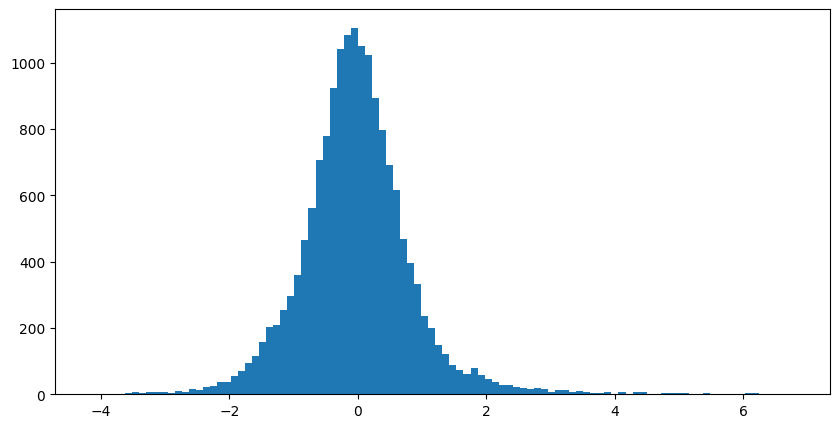

media istogramma -0.019460456


In [210]:
difference=(Yp_mean_mean-Y_test_mean).flatten()
plt.figure(figsize=(10,5),dpi=100)
plt.hist(difference,bins=100)
plt.show()
print("media istogramma",np.mean(difference))

In [211]:
print(Yp_mean_std)

[0.18505287 0.18161231 0.20015766 ... 0.24213776 0.27515975 0.28710622]


In [212]:
from scipy.stats import shapiro
# Esegui il test di Shapiro-Wilk
stat, p = shapiro(difference)
# Stampa il risultato del test
print("Test di Shapiro-Wilk:")
print(f"Statistiche del test: {stat}")
print(f"P-value: {p}")
# Interpreta il risultato
if p > 0.05:
    print("Gli errori seguono una distribuzione normale (non c'è evidenza per il rifiuto dell'ipotesi nulla).")
else:
    print("Gli errori non seguono una distribuzione normale (c'è evidenza per il rifiuto dell'ipotesi nulla).")

from scipy.stats import kstest
# Esegui il test di Kolmogorov-Smirnov contro una distribuzione normale
stat, p = kstest(difference, 'norm')
# Stampa il risultato del test
print("Test di Kolmogorov-Smirnov:")
print(f"Statistiche del test: {stat}")
print(f"P-value: {p}")
# Interpreta il risultato
if p > 0.05:
    print("Gli errori seguono una distribuzione normale (non c'è evidenza per il rifiuto dell'ipotesi nulla).")
else:
    print("Gli errori non seguono una distribuzione normale (c'è evidenza per il rifiuto dell'ipotesi nulla).")


Test di Shapiro-Wilk:
Statistiche del test: 0.9394695417505331
P-value: 2.8168834147616172e-62
Gli errori non seguono una distribuzione normale (c'è evidenza per il rifiuto dell'ipotesi nulla).
Test di Kolmogorov-Smirnov:
Statistiche del test: 0.09641878412896554
P-value: 4.929027318510554e-133
Gli errori non seguono una distribuzione normale (c'è evidenza per il rifiuto dell'ipotesi nulla).


In [213]:
#most basic and simple conformal calibration

In [214]:
dati_empirici=difference
percentile_5 = np.percentile(dati_empirici, 5)   # Limite inferiore (5° percentile)
percentile_95 = np.percentile(dati_empirici, 95) # Limite superiore (95° percentile)

# Intervallo di confidenza
IC_inferiore = percentile_5
IC_superiore = percentile_95

print(f"Intervallo di confidenza inferiore: {IC_inferiore}")
print(f"Intervallo di confidenza superiore: {IC_superiore}")

Intervallo di confidenza inferiore: -1.3644174575805663
Intervallo di confidenza superiore: 1.3266357421874997


In [215]:
intervallo_inferiore = Yp_mean_mean - (IC_superiore)
intervallo_superiore = Yp_mean_mean - (IC_inferiore)

intervallo_inferiore=intervallo_inferiore.flatten()
intervallo_superiore =intervallo_superiore.flatten()

In [216]:
print(intervallo_superiore.shape)
print(Yp_mean_mean.shape)
print(Yp_mean_mean)
print(intervallo_superiore)
print(intervallo_inferiore )

(16385,)
(16385,)
[-1.5435741 -1.4743465 -1.8665464 ... 16.367073  16.178188  15.539099 ]
[-0.17915666 -0.10992908 -0.50212896 ... 17.731491   17.542606
 16.903517  ]
[-2.8702097 -2.8009822 -3.193182  ... 15.040438  14.851553  14.212463 ]


In [217]:
#risultato in validation autoamticamente coperto

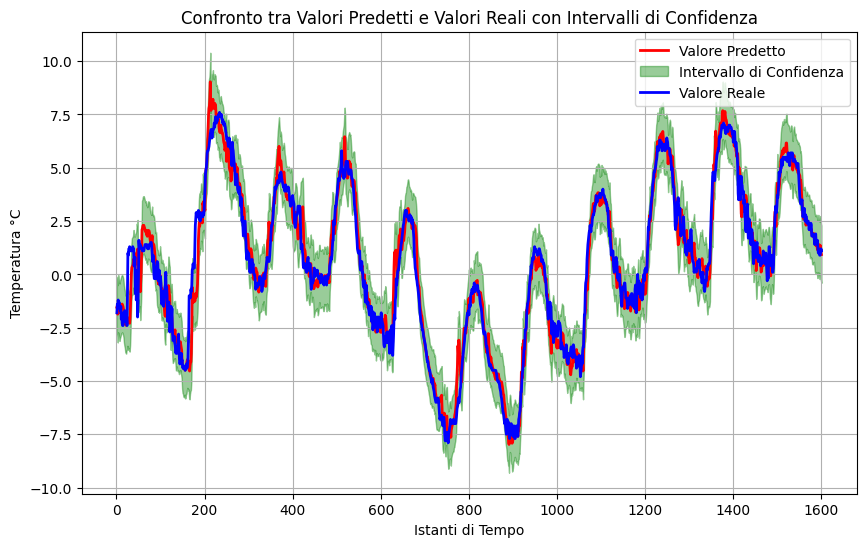

In [218]:
intervallo_inferiore_array = np.full_like(Yp_mean_mean, intervallo_inferiore)
intervallo_superiore_array = np.full_like(Yp_mean_mean, intervallo_superiore)

# Crea un array di istanti di tempo (puoi personalizzarlo in base alla tua data)
istanti_tempo = np.arange(1, len(Yp_mean_mean) + 1)

# Crea il grafico con stili personalizzati
plt.figure(figsize=(10, 6))
N=1600
plt.plot(istanti_tempo[:N], Yp_mean_mean[:N], 'r-', label='Valore Predetto', linewidth=2)
plt.fill_between(istanti_tempo[:N], intervallo_inferiore_array[:N], intervallo_superiore_array[:N], color='green', alpha=0.4, label='Intervallo di Confidenza')
plt.plot(istanti_tempo[:N], Y_test_mean[:N], 'b-', label='Valore Reale', linewidth=2)
plt.xlabel('Istanti di Tempo')
plt.ylabel('Temperatura °C')
plt.title('Confronto tra Valori Predetti e Valori Reali con Intervalli di Confidenza')
plt.legend()
plt.grid(True)
plt.show()

In [219]:
#test

loading model
(16116, 1, 1, 2)
MAE mean: 0.655 | MSE mean: 0.843830
MAE std: 0.107 | MSE std: 0.023988


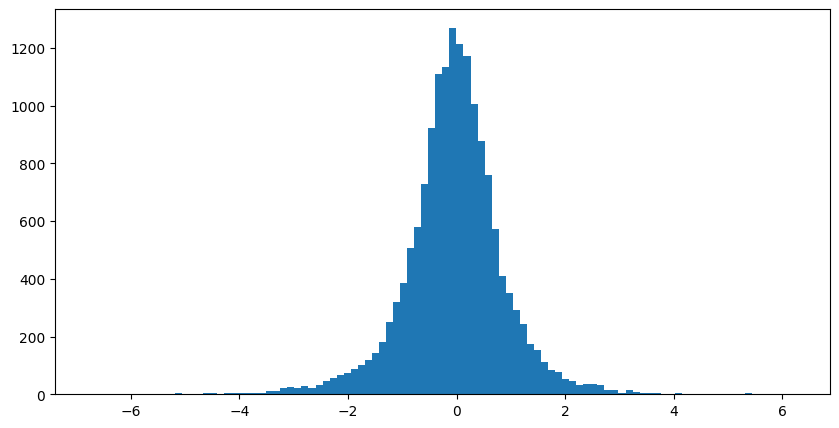

media istogramma -0.041955784


In [220]:

label_len=50
seq_len=100
pred_len=6*1
forecaster = DNNModel(batch_size=1, seq_len=100, label_len=50, lr=0.0015,d_model=24,factor=1,weight_decay=0,e_layers=1,n_heads=1,d_ff=16,p_hidden_dims=16,p_hidden_layers=2,d_layers=1, dropout=0)
setting = '{}'.format('EMANUELE')
Yp_mean ,Y_test= forecaster.test(setting, test=True)
Yp_mean_mean =Yp_mean[:,:,0,-2:-1]
Yp_mean_std =Yp_mean[:,:,0,-1:]
print(Y_test.shape)
Y_test_mean = Y_test[:,:,0,-2:-1]
Y_test_std = Y_test[:,:,0,-1:]
data=Dataset(flag='test',size=[seq_len,label_len,pred_len])
Y_test_mean = data.inverse_transform_mean(Y_test_mean.reshape(-1, 1)).flatten()
Yp_mean_mean = data.inverse_transform_mean(Yp_mean_mean.reshape(-1, 1)).flatten()
Y_test_std = data.inverse_transform_std(Y_test_std.reshape(-1, 1)).flatten()
Yp_mean_std = data.inverse_transform_std(Yp_mean_std.reshape(-1, 1)).flatten()
#print(Y_test.shape)
mae_validation_mean = np.mean(MAE(Yp_mean_mean, Y_test_mean))
mse_validation_mean = np.mean(MSE(Yp_mean_mean, Y_test_mean))
print("MAE mean: {:.3f} | MSE mean: {:.6f}".format(mae_validation_mean,mse_validation_mean))

mae_validation_std = np.mean(MAE(Yp_mean_std, Y_test_std))
mse_validation_std = np.mean(MSE(Yp_mean_std, Y_test_std))
print("MAE std: {:.3f} | MSE std: {:.6f}".format(mae_validation_std,mse_validation_std))
difference=(Yp_mean_mean-Y_test_mean).flatten()
plt.figure(figsize=(10,5),dpi=100)
plt.hist(difference,bins=100)
plt.show()
print("media istogramma",np.mean(difference))

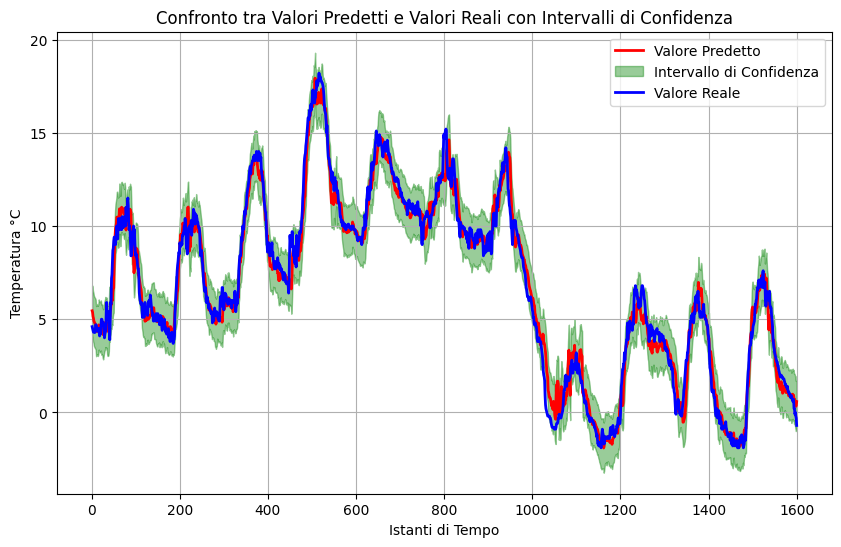

In [222]:
intervallo_inferiore = Yp_mean_mean - (IC_superiore)
intervallo_superiore = Yp_mean_mean - (IC_inferiore)

intervallo_inferiore=intervallo_inferiore.flatten()
intervallo_superiore =intervallo_superiore.flatten()

intervallo_inferiore_array = np.full_like(Yp_mean_mean, intervallo_inferiore)
intervallo_superiore_array = np.full_like(Yp_mean_mean, intervallo_superiore)

# Crea un array di istanti di tempo (puoi personalizzarlo in base alla tua data)
istanti_tempo = np.arange(1, len(Yp_mean_mean) + 1)

# Crea il grafico con stili personalizzati
plt.figure(figsize=(10, 6))
N=1600
plt.plot(istanti_tempo[:N], Yp_mean_mean[:N], 'r-', label='Valore Predetto', linewidth=2)
plt.fill_between(istanti_tempo[:N], intervallo_inferiore_array[:N], intervallo_superiore_array[:N], color='green', alpha=0.4, label='Intervallo di Confidenza')
plt.plot(istanti_tempo[:N], Y_test_mean[:N], 'b-', label='Valore Reale', linewidth=2)
plt.xlabel('Istanti di Tempo')
plt.ylabel('Temperatura °C')
plt.title('Confronto tra Valori Predetti e Valori Reali con Intervalli di Confidenza')
plt.legend()
plt.grid(True)

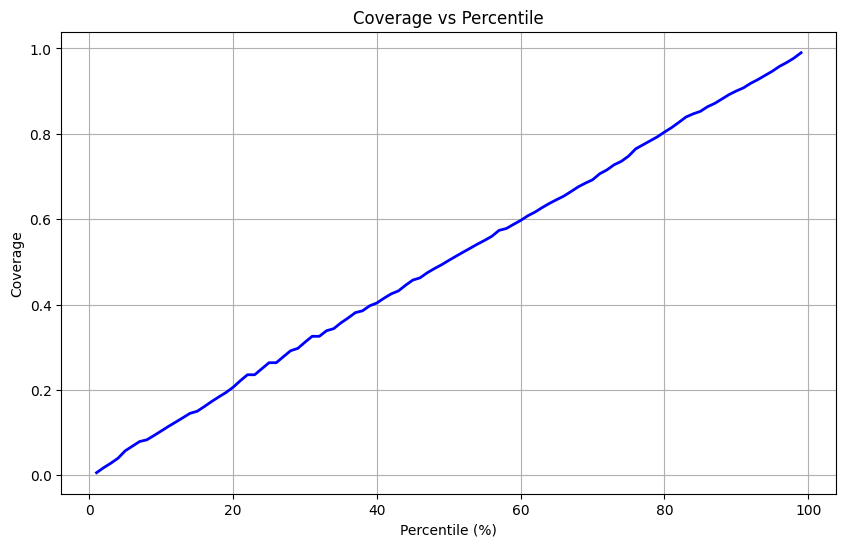

In [223]:
intervallo_inferiore_array = np.full_like(Yp_mean_mean, intervallo_inferiore)
intervallo_superiore_array = np.full_like(Yp_mean_mean, intervallo_superiore)

# Calcoliamo la coverage per diversi percentili
percentili = np.arange(1, 100, 1)
coverage = []

# Calcolo della coverage per ogni percentile
for p in percentili:
    lower_bound = np.percentile(Yp_mean_mean, (100 - p) / 2)
    upper_bound = np.percentile(Yp_mean_mean, 100 - (100 - p) / 2)
    covered = np.mean((Y_test_mean >= lower_bound) & (Y_test_mean <= upper_bound))
    coverage.append(covered)

# Creazione del grafico Coverage vs Percentili
plt.figure(figsize=(10, 6))
plt.plot(percentili, coverage, 'b-', linewidth=2)
plt.xlabel('Percentile (%)')
plt.ylabel('Coverage')
plt.title('Coverage vs Percentile')
plt.grid(True)
plt.show()
